# Introducción

El siguiente informa abarca estudios en torno a la educación primaria y secundaria en Chile, y tiene como principal objetivo caracterizar la relación entre el promedio general y distintas variables, como la condición de ruralidad, región geográfica, género, tipo de dependencia. Estas variables están presentes en el mismo dataset otorgado por el MINEDUC, que contiene gran información acerda de tres millones de estudiantes. Como es bien sabido, Chile es un país muy desigual y sumamente segregado en varios ámbitos. El objetivo de este proyecto es buscar patrones en los datos que puedan reflejar estas desigualdades.

El informe contiene análisis y síntesis de distintas observaciones en torno a los estudios y visualizaciones del comportamiento de estas variables.

# Exploración


In [147]:
import pandas as pd
import numpy as np

rendimiento = pd.read_csv("datos/mineduc/rendimiento_escolar/2020.csv",
                          sep=";", decimal=",",
                          dtype={
                              "NOM_RBD":"category",
                              "NOM_REG_RBD_A":"category",
                              "NOM_COM_RBD":"category",
                              "NOM_DEPROV_RBD":"category",
                              "LET_CUR":"category",
                              "GEN_ALU":"category",
                              "NOM_COM_ALU":"category",
                              "SIT_FIN":"category",
                              "SIT_FIN_R":"category",
                              "RURAL_RBD":"category",
                              "COD_DEPE":"category",
                              "COD_DEPE2":"category",
                              "ESTADO_ESTAB":"category",
                              "COD_ENSE":"category",
                              "COD_ENSE2":"category"},
                          converters={"EDAD_ALU": lambda s : int(s) if s != ' ' else 0})

In [148]:
# cambio de nombre para algunas categorias
rendimiento.GEN_ALU.cat.categories = ["HOMBRE", "MUJER", "S/I"]

rendimiento.RURAL_RBD.cat.categories = ["URBANO", "RURAL"]


rendimiento.COD_DEPE = rendimiento.COD_DEPE.cat.rename_categories(
    {"1":"CORP_MUNICIPAL", "2":"MUNICIPAL_DAEM", "3":"PARTICULAR_SUBVEN",
     "4":"PARTICULAR_PAGADO", "5":"CORP_ADMIN_DELEGD", "6":"SERVI_LOCAL_EDUCA"})
rendimiento.COD_DEPE2 = rendimiento.COD_DEPE2.cat.rename_categories(
    {"1":"Municipal", "2":"Particular subvencionado", "3":"Particular pagado", 
     "4":"Corp. admin. delegada", "5":"Serv. local educación"}
)

rendimiento.ESTADO_ESTAB = rendimiento.ESTADO_ESTAB.cat.rename_categories(
    {"1":"FUNCIONANDO","2":"RECESO", "3":"CERRADO"}
)

rendimiento.SIT_FIN = rendimiento.SIT_FIN.cat.rename_categories(
    {" ":"SIN_INFO", "P":"PROMOVIDO", "R":"REPROBADO", "Y":"RETIRADO"}
)

rendimiento.SIT_FIN_R = rendimiento.SIT_FIN_R.cat.rename_categories (
    {" ":"SIN_INFO", "P":"PROMOVIDO", "R":"REPROBADO", "Y":"RETIRADO", "T":"TRASLADADO"}
)

rendimiento.COD_ENSE2 = rendimiento.COD_ENSE2.cat.rename_categories(
    {"2":"Básica Niños", "3":"Básica Adultos", 
     "5":"Media HC Jóvenes", "6":"Media HC Adultos",
     "7":"Media TP Jóvenes", "8":"Media TP Adultos"}
)
pass

In [149]:
rendimiento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3164534 entries, 0 to 3164533
Data columns (total 37 columns):
 #   Column          Dtype   
---  ------          -----   
 0   AGNO            int64   
 1   RBD             int64   
 2   DGV_RBD         int64   
 3   NOM_RBD         category
 4   COD_REG_RBD     int64   
 5   NOM_REG_RBD_A   category
 6   COD_PRO_RBD     int64   
 7   COD_COM_RBD     int64   
 8   NOM_COM_RBD     category
 9   COD_DEPROV_RBD  int64   
 10  NOM_DEPROV_RBD  category
 11  COD_DEPE        category
 12  COD_DEPE2       category
 13  RURAL_RBD       category
 14  ESTADO_ESTAB    category
 15  COD_ENSE        category
 16  COD_ENSE2       category
 17  COD_GRADO       int64   
 18  LET_CUR         category
 19  COD_JOR         int64   
 20  COD_TIP_CUR     int64   
 21  COD_DES_CUR     int64   
 22  MRUN            int64   
 23  GEN_ALU         category
 24  FEC_NAC_ALU     int64   
 25  EDAD_ALU        int64   
 26  COD_REG_ALU     int64   
 27  COD_COM_ALU 

El dataset abarca más de 3 millones de alumnos.

Si bien hay muchas columnas, los datos que estas proveen pueden ser agrupados en menos categorías:

- Identificación del alumno: edad, género, y lugar de residencia
- Rendimiento del alumno: curso, promedio general y porcentaje de asistencia
- Identificación del colegio: identificador único (RBD), ubicación, administración (municipal, particular subvencionado, etc.).
- Tipo de enseñanza: técnico-profesional, científico-humanista, para adultos, etc.

## Cobertura

In [150]:
print(f"Hay {len(rendimiento.COD_PRO_RBD.unique())} provincias, "
    + f"{len(rendimiento.COD_COM_RBD.unique())} comunas"
    + f" y {len(rendimiento.RBD.unique())} establecimientos distintos.")

Hay 56 provincias, 345 comunas y 9040 establecimientos distintos.


Chile tiene 56 provincias y 346 comunas, es decir, hay una sola comuna para la cual no hay ningún establecimiento en los datos. Todo el resto del territorio debiese estar representado.

De una [fuente externa](https://www.bcn.cl/siit/estadisticasterritoriales//resultados-consulta?id=82491) se obtiene que en Chile existen 11342 establecimientos educacionales, de los cuales 9040 están presentes en los datos. No está claro por qué estos establecimientos están ausentes, pero es probable que sean aquellos con menor cantidad de estudiantes. En general, el dataset parece ser bastante completo.

## Datos faltantes o incompletos

In [151]:
rendimiento.isna().describe()

,AGNO,RBD,DGV_RBD,NOM_RBD,COD_REG_RBD,NOM_REG_RBD_A,COD_PRO_RBD,COD_COM_RBD,NOM_COM_RBD,COD_DEPROV_RBD,...,COD_COM_ALU,NOM_COM_ALU,COD_RAMA,COD_SEC,COD_ESPE,PROM_GRAL,ASISTENCIA,SIT_FIN,SIT_FIN_R,COD_MEN
count,3164534,3164534,3164534,3164534,3164534,3164534,3164534,3164534,3164534,3164534,...,3164534,3164534,3164534,3164534,3164534,3164534,3164534,3164534,3164534,3164534
unique,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,3164534,3164534,3164534,3164534,3164534,3164534,3164534,3164534,3164534,3164534,...,3164534,3164534,3164534,3164534,3164534,3164534,3164534,3164534,3164534,3164534


Aparentemente no existen datos faltantes, pero esto se debe a que los valores faltantes o incompletos están codificados de otro modo. Por ejemplo, la edad faltante se codifica con el valor 0.

In [152]:
# situacion final (aprobado, reprobado)
print(f"Sin info. de situación final: {(rendimiento.SIT_FIN_R == 'SIN_INFO').sum()}")

# genero
print(f"Sin género: {(rendimiento.GEN_ALU == 'S/I').sum()}")

# edad
print(f"Sin edad: {(rendimiento.EDAD_ALU == 0).sum()}")

# lugar de residencia
print(f"Sin lugar: {((rendimiento.COD_REG_ALU == 0) | (rendimiento.COD_COM_ALU == 0)).sum()}")

# alumnos retirados (promedio 0)
print(f"Sin promedio: {(rendimiento.PROM_GRAL == 0.0).sum()}")

Sin info. de situación final: 1197
Sin género: 5
Sin edad: 636
Sin lugar: 2
Sin promedio: 115617


En general hay pocos datos faltantes. La categoría más importante son los alumnos cuyo promedio fue ingresado como `0,0`. Todos estos datos pueden ser retirados del dataset.

In [153]:
rendimiento.drop(rendimiento[rendimiento.SIT_FIN_R == "SIN_INFO"].index, inplace = True)
rendimiento.drop(rendimiento[rendimiento.GEN_ALU == "S/I"].index, inplace = True)
rendimiento.drop(rendimiento[rendimiento.EDAD_ALU == 0].index, inplace = True)
rendimiento.drop(rendimiento[(rendimiento.COD_REG_ALU == 0) | (rendimiento.COD_COM_ALU == 0)].index, inplace = True)
rendimiento.drop(rendimiento[rendimiento.PROM_GRAL == 0.0].index, inplace = True)

## Distribución

### Región

<AxesSubplot:>

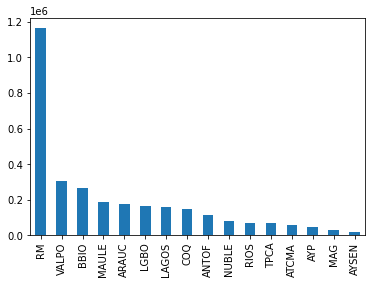

In [154]:
rendimiento["NOM_REG_RBD_A"].value_counts().plot(kind="bar")

Los alumnos se concentran en la región metropolitana. Las regiones de Valparaíso y Bio Bio son las que mayor cantidad de alumnos tienen sin contar la metropolitana, mientras que Aysen y Magallanes tienen la menor cantidad.

### Ruralidad

<AxesSubplot:ylabel='RURAL_RBD'>

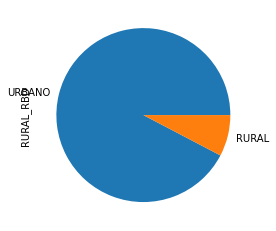

In [155]:
rendimiento.RURAL_RBD.value_counts().plot(kind="pie")

Así mismo,la mayoría (92%) de los estudiantes se encuentran en zonas urbanas.

### Tipo de establecimiento

<AxesSubplot:ylabel='COD_DEPE'>

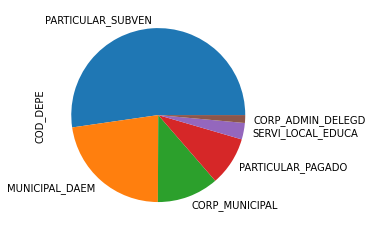

In [156]:
rendimiento.COD_DEPE.value_counts().plot(kind="pie")

Alrededor de la mitad de los estudiantes en Chile asiste a colegios particulares subvencionados. El servicio local de educación corresponde a un 3%, mientras que la corporación administración delegada corresponde al 1% del tipo de establecimientos del país.

<AxesSubplot:ylabel='COD_DEPE2'>

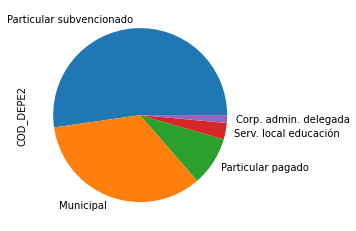

In [157]:
rendimiento.COD_DEPE2.value_counts().plot(kind="pie")

## Promedios
### Ruralidad

In [158]:
rendimiento.groupby("RURAL_RBD").PROM_GRAL.describe()

,count,mean,std,min,25%,50%,75%,max
RURAL_RBD,,,,,,,,
URBANO,2814218.0,6.000115,0.896840,1.0,5.5,6.2,6.7,7.0
RURAL,234122.0,5.945313,0.846167,1.0,5.4,6.1,6.6,7.0


No se observan diferencias de promedio significativas entre estudiantes rurales y urbanos.

### Dependencia

In [159]:
rendimiento.groupby("COD_DEPE2").PROM_GRAL.describe()

,count,mean,std,min,25%,50%,75%,max
COD_DEPE2,,,,,,,,
Particular subvencionado,1593539.0,6.033265,0.875713,1.0,5.6,6.2,6.7,7.0
Serv. local educación,93145.0,5.795030,0.963001,1.0,5.2,6.0,6.6,7.0
Municipal,1039401.0,5.844379,0.931466,1.0,5.3,6.0,6.6,7.0
Particular pagado,277847.0,6.494710,0.508951,1.0,6.3,6.6,6.9,7.0
Corp. admin. delegada,44408.0,5.502405,0.946931,1.0,5.0,5.6,6.2,7.0


### Género

In [160]:
rendimiento.groupby("GEN_ALU").PROM_GRAL.describe()

,count,mean,std,min,25%,50%,75%,max
GEN_ALU,,,,,,,,
HOMBRE,1561238.0,5.927001,0.925737,1.0,5.4,6.1,6.6,7.0
MUJER,1487102.0,6.068247,0.851671,1.0,5.6,6.3,6.7,7.0
S/I,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Región

In [161]:
rendimiento.groupby("NOM_REG_RBD_A").PROM_GRAL.describe()

,count,mean,std,min,25%,50%,75%,max
NOM_REG_RBD_A,,,,,,,,
AYP,44742.0,6.039770,0.880625,1.0,5.6,6.3,6.7,7.0
TPCA,67970.0,5.991477,0.891894,1.0,5.5,6.2,6.7,7.0
ANTOF,113031.0,5.961813,0.883237,1.0,5.4,6.2,6.7,7.0
ATCMA,56233.0,6.015763,0.850892,1.0,5.6,6.2,6.7,7.0
COQ,145082.0,5.983524,0.891424,1.0,5.5,6.2,6.7,7.0
VALPO,307095.0,6.000204,0.933599,1.0,5.5,6.2,6.7,7.0
LGBO,164308.0,5.933132,0.933789,1.0,5.4,6.1,6.7,7.0
MAULE,185731.0,6.004445,0.932554,1.0,5.5,6.2,6.7,7.0
NUBLE,81068.0,6.109844,0.794929,1.0,5.6,6.3,6.7,7.0


### Nivel de enseñanza

In [162]:
rendimiento.groupby("COD_ENSE2").PROM_GRAL.describe()

,count,mean,std,min,25%,50%,75%,max
COD_ENSE2,,,,,,,,
Básica Niños,2021634.0,6.110023,0.800784,1.0,5.7,6.3,6.8,7.0
Básica Adultos,16935.0,4.861140,1.441165,1.0,4.0,5.1,6.0,7.0
Media HC Jóvenes,661768.0,5.983947,0.840859,1.0,5.5,6.2,6.6,7.0
Media HC Adultos,99891.0,5.002931,1.468828,1.0,4.4,5.4,6.1,7.0
Media TP Jóvenes,240176.0,5.593820,0.931167,1.0,5.1,5.7,6.3,7.0
Media TP Adultos,7936.0,5.011794,1.391807,1.0,4.4,5.3,6.0,7.0


### Resumen

En general la distribución de las notas es bastante uniforme. Las notas en areas rurales son ligeramente inferiores a las areas urbanas. Por género, las mujeres tienen notas levemente superiores. Por región, sólo Magallanes parece tener una distribución notablemente diferente al resto, tendiendo a ser mejor. La edad de los alumnos también es similar por región, por lo que los promedios son comparables.

Un criterio que arroja diferencias claras es el tipo de establecimiento, donde se observa una jerarquía con los colegios particulares pagados arriba, los sobvencionados en medio y los municipales abajo. El otro criterio es el nivel de enseñanza: los códigos 3, 6 y 8, que corresponden a educación para adultos, tienen una varianza mucho mayor y un promedio más bajo que la educación para jóvenes. Además, dentro de la educación para jóvenes se ve que la enseñanza técnico profesional tienen promedios más bajos que la humanistico científica.

Puesto que los datos de adultos tienen tanta varianza, se puede repetir el análisis considerando únicamente a los jóvenes.

## Promedios (sólo niños y jóvenes)

In [178]:
rend_jovenes = rendimiento.drop(
    rendimiento[(rendimiento.COD_ENSE2 == "Básica Adultos") 
                | (rendimiento.COD_ENSE2 == "Media HC Adultos") 
                | (rendimiento.COD_ENSE2 == "Media TP Adultos")].index)

### Ruralidad

In [179]:
rend_jovenes.groupby("RURAL_RBD").PROM_GRAL.describe()

,count,mean,std,min,25%,50%,75%,max
RURAL_RBD,,,,,,,,
URBANO,2695002.0,6.045238,0.834677,1.0,5.6,6.2,6.7,7.0
RURAL,228576.0,5.966449,0.819363,1.0,5.5,6.1,6.6,7.0


### Dependencia

In [180]:
rend_jovenes.groupby("COD_DEPE2").PROM_GRAL.describe()

,count,mean,std,min,25%,50%,75%,max
COD_DEPE2,,,,,,,,
Particular subvencionado,1524616.0,6.083128,0.799770,1.0,5.6,6.3,6.7,7.0
Serv. local educación,88123.0,5.851146,0.893505,1.0,5.3,6.0,6.6,7.0
Municipal,990505.0,5.883703,0.885410,1.0,5.3,6.0,6.6,7.0
Particular pagado,275992.0,6.499144,0.503322,1.0,6.3,6.6,6.9,7.0
Corp. admin. delegada,44342.0,5.505219,0.941752,1.0,5.0,5.6,6.2,7.0


### Género

In [181]:
rend_jovenes.groupby("GEN_ALU").PROM_GRAL.describe()

,count,mean,std,min,25%,50%,75%,max
GEN_ALU,,,,,,,,
HOMBRE,1492881.0,5.977815,0.860580,1.0,5.5,6.2,6.7,7.0
MUJER,1430697.0,6.103004,0.799831,1.0,5.7,6.3,6.7,7.0
S/I,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Región

In [182]:
rend_jovenes.groupby("NOM_REG_RBD_A").PROM_GRAL.describe()

,count,mean,std,min,25%,50%,75%,max
NOM_REG_RBD_A,,,,,,,,
AYP,42486.0,6.097889,0.804721,1.0,5.6,6.3,6.7,7.0
TPCA,64496.0,6.037412,0.840969,1.0,5.5,6.2,6.7,7.0
ANTOF,109538.0,5.982981,0.861302,1.0,5.5,6.2,6.7,7.0
ATCMA,54640.0,6.042432,0.820283,1.0,5.6,6.2,6.7,7.0
COQ,137639.0,6.039041,0.805258,1.0,5.6,6.2,6.7,7.0
VALPO,290014.0,6.061988,0.842519,1.0,5.6,6.3,6.7,7.0
LGBO,157929.0,5.977555,0.876298,1.0,5.4,6.2,6.7,7.0
MAULE,179185.0,6.056323,0.854673,1.0,5.6,6.3,6.7,7.0
NUBLE,79149.0,6.132090,0.766390,1.0,5.7,6.3,6.8,7.0


### Tipo de enseñanza

In [183]:
rend_jovenes.COD_ENSE = rend_jovenes.COD_ENSE.cat.rename_categories(
    {"110":"Básica",
     "310":"Media HC",
     "410":"Media TP Comercial",
     "510":"Media TP Industrial",
     "610":"Media TP Técnica",
     "710":"Media TP Agrícola",
     "810":"Media TP Marítima",
     "910":"Media Artística"}
)
rend_jovenes.COD_ENSE = rend_jovenes.COD_ENSE.cat.remove_unused_categories()

rend_jovenes.groupby("COD_ENSE").PROM_GRAL.describe()

,count,mean,std,min,25%,50%,75%,max
COD_ENSE,,,,,,,,
Básica,2021634.0,6.110023,0.800784,1.0,5.7,6.3,6.8,7.0
Media HC,661768.0,5.983947,0.840859,1.0,5.5,6.2,6.6,7.0
Media TP Comercial,68856.0,5.624037,0.942173,1.0,5.1,5.8,6.3,7.0
Media TP Industrial,97001.0,5.535835,0.922091,1.0,5.0,5.6,6.2,7.0
Media TP Técnica,54061.0,5.676208,0.922826,1.0,5.2,5.8,6.3,7.0
Media TP Agrícola,16075.0,5.553667,0.933443,1.0,5.1,5.7,6.2,7.0
Media TP Marítima,3710.0,5.517466,0.982150,1.0,5.0,5.7,6.2,7.0
Media Artística,473.0,5.633404,0.693511,3.0,5.3,5.7,6.1,7.0


### Curso
#### Básica

In [186]:
rend_jovenes[rend_jovenes.COD_ENSE == "Básica"].groupby("COD_GRADO").PROM_GRAL.describe()

,count,mean,std,min,25%,50%,75%,max
COD_GRADO,,,,,,,,
1,243881.0,6.337846,0.862165,1.0,6.1,6.7,6.9,7.0
2,248618.0,6.343828,0.798739,1.0,6.1,6.7,6.9,7.0
3,255417.0,6.260551,0.775006,1.0,5.9,6.5,6.8,7.0
4,259472.0,6.211636,0.743410,1.0,5.9,6.4,6.8,7.0
5,259578.0,6.058206,0.755322,1.0,5.6,6.2,6.6,7.0
6,258728.0,5.973108,0.758433,1.0,5.5,6.1,6.6,7.0
7,253018.0,5.847941,0.770140,1.0,5.4,6.0,6.5,7.0
8,242922.0,5.849377,0.755202,1.0,5.4,6.0,6.4,7.0


#### Media

In [187]:
rend_jovenes[rend_jovenes.COD_ENSE != "Básica"].groupby("COD_GRADO").PROM_GRAL.describe()

,count,mean,std,min,25%,50%,75%,max
COD_GRADO,,,,,,,,
1,243768.0,5.717712,0.914601,1.0,5.2,5.9,6.4,7.0
2,230015.0,5.862517,0.843888,1.0,5.4,6.0,6.5,7.0
3,218933.0,5.887909,0.930695,1.0,5.4,6.1,6.6,7.0
4,209228.0,6.080288,0.790426,1.0,5.7,6.3,6.7,7.0


### Resumen

Como es de esperarse dado los jóvenes son la mayoría de los estudiantes, la tendencia general se mantienen, con la excepción en el caso de los promedios por región, donde las diferencias se hacen más evidentes. En los promedios por curso se observa que tiende a descender en los cursos superiores, pero en la media la tendencia es la inversa.

Este análisis no revela patrones demasiado evidentes. De todos modos, puesto que los colegios no necesariamente evalúan con el mismo estándar de notas, no está claro que tan comparables son las notas de alumnos que asisten a colegios distintos. En este sentido, podría ser útil hacer comparaciones entre alumnos del mismo colegio. Por ejemplo: comparar resultados de alumnos que estudian en la misma comuna donde viven con los de alumnos que estudian en colegios de otras comunas.


### Promedio según comuna de estudio

In [189]:
rend_jovenes["MISMA_COMUNA"] = rend_jovenes.COD_COM_RBD == rend_jovenes.COD_COM_ALU

rend_jovenes.groupby("MISMA_COMUNA").PROM_GRAL.describe()

,count,mean,std,min,25%,50%,75%,max
MISMA_COMUNA,,,,,,,,
False,708430.0,6.012299,0.848627,1.0,5.5,6.2,6.7,7.0
True,2215148.0,6.047643,0.828764,1.0,5.6,6.2,6.7,7.0


El promedio general de los alumnos que estudian en la comuna en la que viven y el de aquellos que no parece distribuirse del mismo modo.

# Preguntas y problemas

Al examinar el dataset se hace evidente que muchas variables no tienen el poder predictivo que se esperaba. Las diferencias más marcadas se dan en relación a la ubicación geográfica y el código de dependencia. Creemos que esto se debe a que los sistemas de evaluación utilizados por los colegios no están estandarizados mucho más allá de la escala de notas y los contenidos a pasar. Hay una multiplicidad de variables que afectan la forma en que los colegios evalúan a sus alumnos, por lo que las notas son poco comparables entre alumnos de colegios distintos. En consecuencia, es evidente que es necesario añadir datos que sean comparables entre colegios, o bien, derivar tales variables a partir de los atributos ya existentes. Por ejemplo, se puede considerar la distribución de notas de los colegios y tomar en cuenta la posición del alumno en relación a sus compañeros. 

Es necesario, entonces, buscar relaciones más complejas entre las variables. Al comparar promedios una variable a la vez se hace difícil observar tendencias. Por tanto, nos interesa utilizar algoritmos de clustering para determinar si existen combinaciones de variables que generen grupos de alumnos con rendimiento escolar similar. En general, del análisis de datos como los resultados de la PSU se observa que en Chile existe esta segregación, y nos interesa determinar si es posible identificarlos con los datos disponibles en este dataset.

Para poder formular preguntas más interesantes, utilizaremos [datos de la prueba de transición](http://datos.mineduc.cl/dashboards/21331/descarga-bases-de-datos-de-prueba-de-transicion-universitaria-2021/) para obtener una métrica comparable entre alumnos de colegios distintos. Además de los puntajes obtenidos por los alumnos, se encuentra también disponible información sobre sus postulaciones y matrícula. Puesto que todos estos datos están indexados de acuerdo a la máscara del RUN debería ser posible consolidarlos en una única base de datos con varios atributos.

En esencia, nuestro objetivo sigue siendo el mismo: encontrar agrupaciones en los datos que puedan ser indicativas de segregación.

# Propuesta experimental

## Consolidación del dataset

Del dataset de rendimiento académico se tomará:
- Colegio
- Dependencia del colegio (municipal, subvencionado, etc.)
- Región y comuna del colegio
- Ruralidad del colegio (si/no)
- Región y comuna de residencia del alumno
- Género del alumno

Del dataset de puntajes de la prueba de transición:
- Promedio notas de enseñanza media del alumno
- Puntaje lenguaje, matemáticas y pruebas específicas

Y del dataset de matrícula:
- Universidad 
- Carrera
- Sede/facultad

## Experimentos

## Implementación

### Consolidación de datos

In [207]:
# puntajes PTU
puntajes = pd.read_csv("datos/mineduc/PDT/puntajes_2021.csv", sep=";", decimal=",", low_memory=False, na_values=" ")

# datos de matrícula
matricula = pd.read_csv("datos/mineduc/PDT/matricula_2021.csv", sep=";", decimal=",", low_memory=False,
                       dtype={"NOMBRE_INSTITUCION":"category", "NOMBRE_CARRERA":"category", "SEDE":"category"})

In [213]:
puntajes = puntajes[["MRUN", "PROMEDIO_NOTAS", "CLEC_ACTUAL", "MATE_ACTUAL", "HCSO_ACTUAL", "CIEN_ACTUAL"]]

matricula = matricula[["MRUN", "NOMBRE_INSTITUCION", "NOMBRE_CARRERA", "SEDE"]]

datos = rend_jovenes[(rend_jovenes.COD_ENSE != "Básica") & (rend_jovenes.COD_GRADO == 4)]

datos = datos[["MRUN", "NOM_RBD", "COD_DEPE2", "NOM_REG_RBD_A", "NOM_COM_RBD", "COD_REG_RBD", "COD_COM_RBD",
               "RURAL_RBD", "COD_REG_ALU", "COD_COM_ALU", "NOM_COM_ALU", "GEN_ALU"]]

KeyError: "['COD_COM_RBDRURAL_RBD'] not in index"

In [209]:
puntajes.info()
matricula.info()
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276059 entries, 0 to 276058
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   MRUN            276059 non-null  int64  
 1   PROMEDIO_NOTAS  272782 non-null  float64
 2   CLEC_ACTUAL     241393 non-null  float64
 3   MATE_ACTUAL     241393 non-null  float64
 4   HCSO_ACTUAL     241393 non-null  float64
 5   CIEN_ACTUAL     241393 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 12.6 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105819 entries, 0 to 105818
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   MRUN                105819 non-null  object  
 1   NOMBRE_INSTITUCION  105819 non-null  category
 2   NOMBRE_CARRERA      105819 non-null  category
 3   SEDE                105819 non-null  category
dtypes: category(3), object(1)
memory usage: 1.2+ MB
